# ANOVA
https://www.reneshbedre.com/blog/anova.html?utm_content=cmp-true

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch

import statsmodels.api as sm
from statsmodels.formula.api import ols

# from bioinfokit.analys import stat

## Ysx in Batch and Fed-batch cultures

### Create DataFrame

In [2]:
offline_data = pd.read_excel("../data/processed_fermentation_data/scale-down_offline_data.xlsx")

# general yield calc
offline_data['o2_yield_mol_cmol'] = offline_data['Consumed_O2']/offline_data['net_glucose_cmol']
offline_data['co2_yield_cmol_cmol'] = offline_data['Formed_CO2']/offline_data['net_glucose_cmol']
offline_data['biomass_yield_cmol_cmol'] = offline_data['net_biomass_cmol']/offline_data['net_glucose_cmol']

# for batch data, because at low conc, OD was more accurate
offline_data['net_biomass_cmol_from_OD'] = (offline_data["OD"]*0.28)*(offline_data["Liquid_volume"]/1000)/24.6

# Add strain name
offline_data["Strain"] = offline_data["Strain Batch"].str.split("-",expand=True)[0]

In [3]:
data_feed_S02 = offline_data[(offline_data["Condition"] == "control") & (offline_data["Timepoint (#)"] == "S02")][["Parent Culture", "Strain", "Timepoint (#)", "net_biomass_cmol_from_OD"]]
data_feed_S02 = data_feed_S02.rename(columns={"net_biomass_cmol_from_OD":"net_biomass_cmol"})
data_feed_S05 = offline_data[(offline_data["Condition"] == "control") & (offline_data["Timepoint (#)"] == "S05")][["Parent Culture", "Strain", "Timepoint (#)", "net_biomass_cmol"]]
data_feed = pd.concat([data_feed_S02, data_feed_S05])
feed_biomass_data = data_feed.pivot(index=["Parent Culture", "Strain"], columns="Timepoint (#)", values="net_biomass_cmol")
feed_biomass_data["biomass_difference"] = feed_biomass_data["S05"] - feed_biomass_data["S02"]
feed_biomass_data = feed_biomass_data.reset_index()
feed_biomass_data = feed_biomass_data[["Parent Culture", "Strain", "biomass_difference"]]
feed_biomass_data.columns.name = None
feed_biomass_data

,Parent Culture,Strain,biomass_difference
0,DDB_PD_117_AMBR_DDB35-005_R05_Main_,DDB35,0.636644
1,DDB_PD_117_AMBR_DDB35-005_R06_Main_,DDB35,0.641830
2,DDB_PD_117_AMBR_DDB35-005_R07_Main_,DDB35,0.626817
3,DDB_PD_121_AMBR_DDB35-006_R05_Main_,DDB35,0.629796
4,DDB_PD_121_AMBR_SDT173-002_R07_Main_,SDT173,0.555040
5,DDB_PD_121_AMBR_SDT178-002_R09_Main_,SDT178,0.525494
6,DDB_PD_121_AMBR_SDT180-003_R11_Main_,SDT180,0.557576
7,DDB_PD_121_AMBR_SDT201-002_R13_Main_,SDT201,0.534505
8,DDB_PD_121_AMBR_SDT202-002_R15_Main_,SDT202,0.616580
9,DDB_PD_122_AMBR_DDB35-006_R05_Main_,DDB35,0.627082


In [4]:
data_feed = offline_data[(offline_data["Condition"] == "control") & ((offline_data["Timepoint (#)"] == "S02") | (offline_data["Timepoint (#)"] == "S05"))][["Parent Culture", "Strain", "Timepoint (#)", "net_glucose_cmol"]]
feed_glucose_data = data_feed.pivot(index=["Parent Culture", "Strain"], columns="Timepoint (#)", values="net_glucose_cmol")
feed_glucose_data["glucose_difference"] = feed_glucose_data["S05"] - feed_glucose_data["S02"]
feed_glucose_data = feed_glucose_data.reset_index()
feed_glucose_data = feed_glucose_data[["Parent Culture", "Strain", "glucose_difference"]]
feed_glucose_data.columns.name = None
feed_glucose_data.head()

,Parent Culture,Strain,glucose_difference
0,DDB_PD_117_AMBR_DDB35-005_R05_Main_,DDB35,1.020044
1,DDB_PD_117_AMBR_DDB35-005_R06_Main_,DDB35,1.020120
2,DDB_PD_117_AMBR_DDB35-005_R07_Main_,DDB35,1.020056
3,DDB_PD_121_AMBR_DDB35-006_R05_Main_,DDB35,1.020021
4,DDB_PD_121_AMBR_SDT173-002_R07_Main_,SDT173,1.020063


In [5]:
data_feed = pd.merge(left=feed_biomass_data, right=feed_glucose_data, how="left")
data_feed["biomass_yield_cmol_cmol"] = data_feed["biomass_difference"]/data_feed["glucose_difference"]
data_feed = data_feed[["Strain", "biomass_yield_cmol_cmol"]]
data_feed["Phase"] = "Fed-batch"
data_feed.head()

,Strain,biomass_yield_cmol_cmol,Phase
0,DDB35,0.624134,Fed-batch
1,DDB35,0.629171,Fed-batch
2,DDB35,0.614493,Fed-batch
3,DDB35,0.617435,Fed-batch
4,SDT173,0.544123,Fed-batch


In [6]:
offline_copy = offline_data.copy()

offline_copy['biomass_yield_cmol_cmol'] = offline_copy['net_biomass_cmol_from_OD']/offline_copy['net_glucose_cmol']
# offline_copy['biomass_yield_cmol_cmol'] = offline_copy['net_biomass_cmol']/offline_copy['net_glucose_cmol']
data_batch = offline_copy[offline_copy['Timepoint (#)'] == 'S02'][["Strain", "biomass_yield_cmol_cmol"]]
data_batch["Phase"] = "Batch"
data_batch.head()

,Strain,biomass_yield_cmol_cmol,Phase
1,DDB35,0.648399,Batch
6,DDB35,0.651474,Batch
11,DDB35,0.676247,Batch
16,DDB35,0.645436,Batch
21,DDB35,0.649684,Batch


In [7]:
data = pd.concat([data_feed, data_batch])

In [8]:
data.head()

,Strain,biomass_yield_cmol_cmol,Phase
0,DDB35,0.624134,Fed-batch
1,DDB35,0.629171,Fed-batch
2,DDB35,0.614493,Fed-batch
3,DDB35,0.617435,Fed-batch
4,SDT173,0.544123,Fed-batch


In [9]:
data[data["Phase"] == "Batch"]

,Strain,biomass_yield_cmol_cmol,Phase
1,DDB35,0.648399,Batch
6,DDB35,0.651474,Batch
11,DDB35,0.676247,Batch
16,DDB35,0.645436,Batch
21,DDB35,0.649684,Batch
26,DDB35,0.657607,Batch
31,DDB35,0.628189,Batch
36,DDB35,0.703346,Batch
41,SDT173,0.615560,Batch
46,SDT173,0.616535,Batch


In [10]:
len(data[data["Phase"] == "Batch"])

41

In [11]:
len(data[data["Phase"] == "Fed-batch"])

20

C:\Users\jonas\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


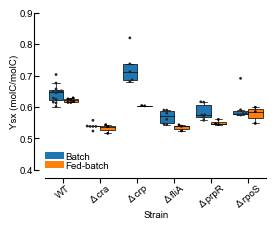

In [12]:
# formatting
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5

plt.rcParams['axes.labelpad']= 0.5
# plt.rcParams['ylabel.pad']= 0

mm_per_inch = 24.5

height_mm = 50
width_mm = 70

fig, ax = plt.subplots(figsize=(width_mm/mm_per_inch,height_mm/mm_per_inch))

df_plotting = data.copy()

order_df = pd.DataFrame()
order_df["Strain"] = ["DDB35", "SDT178", "SDT202", "SDT201", "SDT173", "SDT180"]
order_df["Strain_name"] = ["WT",u"\u0394"+" cra", u"\u0394"+" crp", u"\u0394"+" fliA", u"\u0394"+" prpR", u"\u0394"+" rpoS"]
order_df["order"]  = [1,2,3,4,5,6]

df_plotting = pd.merge(left=df_plotting,right=order_df,how="left")
df_plotting = df_plotting.sort_values("order")

PROPS = {
    'boxprops':{'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}

sns.boxplot(
    x="Strain_name", 
    y="biomass_yield_cmol_cmol", 
    hue="Phase",
    hue_order=["Batch", "Fed-batch"],
    data=df_plotting, 
    palette="tab10",
    saturation=1,
    fliersize=0,
    linewidth=0.5,
    ax=ax, 
    **PROPS
) 

sns.swarmplot(
    data=df_plotting,
    x="Strain_name", 
    y="biomass_yield_cmol_cmol",
    hue="Phase",
    hue_order=["Batch", "Fed-batch"],
    ax=ax,
    color="k",
    size=2,
    dodge=True
)

ax.set_ylim(0.4,0.9)

ax.spines[["top","right"]].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.set_ylabel("Ysx (molC/molC)");
ax.set_xlabel("Strain");
ax.spines["left"].set_position(("axes", -0.05))
ax.spines["bottom"].set_position(("axes", -0.05));
ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=40)

# ax.text(-0.1, 1.05, 'C', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes, fontsize=10);


legend_elements = [
    Patch(facecolor=cm.tab10(0), edgecolor='black',linewidth=0),
    Patch(facecolor=cm.tab10(1), edgecolor='black',linewidth=0)
]

ax.legend(
    legend_elements, 
    ["Batch", "Fed-batch"], 
    fancybox=False,
    bbox_to_anchor=(0.0,0.0),
    loc='lower left',
    ncol=1, 
    # edgecolor='black',
    columnspacing=0.1,
    handletextpad=0.05,
    labelspacing = 0,
    # title='Strain:',
    framealpha=0,
    borderpad=0,
    borderaxespad=0
);

# ax.plot([-0.2,0.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=0, y=0.645, s="***",horizontalalignment="center", verticalalignment="center")

# ax.plot([0.8,1.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=1, y=0.645, s="ns",horizontalalignment="center", verticalalignment="center")

# ax.plot([1.8,2.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=2, y=0.645, s="ns",horizontalalignment="center", verticalalignment="center")

# ax.plot([2.8,3.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=3, y=0.645, s="ns",horizontalalignment="center", verticalalignment="center")

# ax.plot([3.8,4.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=4, y=0.645, s="*",horizontalalignment="center", verticalalignment="center")

# ax.plot([4.8,5.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=5, y=0.645, s="***",horizontalalignment="center", verticalalignment="center")

### Perform ANOVA

In [13]:
data.head()

,Strain,biomass_yield_cmol_cmol,Phase
0,DDB35,0.624134,Fed-batch
1,DDB35,0.629171,Fed-batch
2,DDB35,0.614493,Fed-batch
3,DDB35,0.617435,Fed-batch
4,SDT173,0.544123,Fed-batch


In [14]:
model = ols('biomass_yield_cmol_cmol ~ C(Strain) + C(Phase) + C(Strain):C(Phase)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_table

,sum_sq,df,F,PR(>F)
Intercept,4.960733,1.0,5990.251387,6.792718e-53
C(Strain),0.126678,5.0,30.593484,5.623700e-14
C(Phase),0.001936,1.0,2.337349,1.327347e-01
C(Strain):C(Phase),0.013745,5.0,3.319416,1.164865e-02
Residual,0.040579,49.0,NaN,NaN


In [15]:
# ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=data, res_var='biomass_yield_cmol_cmol', anova_model='biomass_yield_cmol_cmol~C(Strain)+C(Phase)+C(Strain):C(Phase)',ss_typ=3)
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
Intercept,1.0,4.960733,4.960733,5990.251387,6.792718e-53
C(Strain),5.0,0.126678,0.025336,30.593484,5.623700e-14
C(Phase),1.0,0.001936,0.001936,2.337349,1.327347e-01
C(Strain):C(Phase),5.0,0.013745,0.002749,3.319416,1.164865e-02
Residual,49.0,0.040579,0.000828,NaN,NaN


In [16]:
# we will use bioinfokit (v1.0.3 or later) for performing tukey HSD test
# check documentation here https://github.com/reneshbedre/bioinfokit
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
# for main effect Strain
res.tukey_hsd(df=data, res_var='biomass_yield_cmol_cmol', xfac_var='Strain', anova_model='biomass_yield_cmol_cmol~C(Strain)+C(Phase)+C(Strain):C(Phase)', ss_typ=3)
res.tukey_summary

C:\Users\jonas\anaconda3\lib\site-packages\bioinfokit\analys.py:421: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,DDB35,SDT173,0.062514,0.027675,0.097354,7.525247,0.001000
1,DDB35,SDT178,0.098641,0.063802,0.133480,11.874044,0.001000
2,DDB35,SDT180,0.044103,0.009264,0.078942,5.308986,0.005829
3,DDB35,SDT201,0.078033,0.043194,0.112872,9.393347,0.001000
4,DDB35,SDT202,0.056533,0.018520,0.094545,6.237072,0.001000
5,SDT173,SDT178,0.036127,-0.004102,0.076355,3.766169,0.101588
6,SDT173,SDT180,0.018411,-0.021818,0.058640,1.919338,0.725800
7,SDT173,SDT201,0.015519,-0.024710,0.055748,1.617822,0.845399
8,SDT173,SDT202,0.119047,0.076041,0.162054,11.608992,0.001000
9,SDT178,SDT180,0.054538,0.014309,0.094767,5.685507,0.002613


In [17]:
# Note: p-value 0.001 from tukey_hsd output should be interpreted as <=0.001

# for main effect Condition
res.tukey_hsd(df=data, res_var='biomass_yield_cmol_cmol', xfac_var='Phase', anova_model='biomass_yield_cmol_cmol ~ C(Strain) + C(Phase) + C(Strain):C(Phase)',ss_typ=3)
res.tukey_summary

C:\Users\jonas\anaconda3\lib\site-packages\bioinfokit\analys.py:421: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Fed-batch,Batch,0.036069,0.020296,0.051842,6.49895,0.001


In [18]:
# for interaction effect between Strain and Condition
res.tukey_hsd(df=data, res_var='biomass_yield_cmol_cmol', xfac_var=['Strain','Phase'], anova_model='biomass_yield_cmol_cmol ~ C(Strain) + C(Phase) + C(Strain):C(Phase)',ss_typ=3)
res.tukey_summary

C:\Users\jonas\anaconda3\lib\site-packages\bioinfokit\analys.py:387: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[(ele1, ele2)] = df[(df[xfac_var[0]] == ele1) &


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(DDB35, Fed-batch)","(DDB35, Batch)",0.021998,-0.027359,0.071355,2.162105,0.900000
1,"(DDB35, Fed-batch)","(SDT173, Fed-batch)",0.070515,0.000714,0.140317,4.900755,0.045707
2,"(DDB35, Fed-batch)","(SDT173, Batch)",0.036516,-0.020476,0.093509,3.108204,0.551557
3,"(DDB35, Fed-batch)","(SDT178, Fed-batch)",0.088563,0.018762,0.158364,6.155037,0.003560
4,"(DDB35, Fed-batch)","(SDT178, Batch)",0.081683,0.024690,0.138675,6.952713,0.001000
...,...,...,...,...,...,...,...
61,"(SDT201, Fed-batch)","(SDT202, Fed-batch)",0.068706,-0.021407,0.158819,3.698719,0.299845
62,"(SDT201, Fed-batch)","(SDT202, Batch)",0.191889,0.119799,0.263979,12.912642,0.001000
63,"(SDT201, Batch)","(SDT202, Fed-batch)",0.035515,-0.045085,0.116114,2.137561,0.900000
64,"(SDT201, Batch)","(SDT202, Batch)",0.158697,0.098923,0.218472,12.879490,0.001000


In [19]:
res.tukey_summary[(res.tukey_summary["group2"] == ("DDB35", "Batch")) & (res.tukey_summary["group1"] == ("DDB35", "Fed-batch"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(DDB35, Fed-batch)","(DDB35, Batch)",0.021998,-0.027359,0.071355,2.162105,0.9


In [20]:
res.tukey_summary[(res.tukey_summary["group2"] == ("SDT178", "Batch")) & (res.tukey_summary["group1"] == ("SDT178", "Fed-batch"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
38,"(SDT178, Fed-batch)","(SDT178, Batch)",0.00688,-0.062921,0.076681,0.478171,0.9


In [21]:
res.tukey_summary[(res.tukey_summary["group2"] == ("SDT202", "Batch")) & (res.tukey_summary["group1"] == ("SDT202", "Fed-batch"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
65,"(SDT202, Fed-batch)","(SDT202, Batch)",0.123183,0.040593,0.205773,7.235445,0.001


In [22]:
res.tukey_summary[(res.tukey_summary["group2"] == ("SDT201", "Batch")) & (res.tukey_summary["group1"] == ("SDT201", "Fed-batch"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
60,"(SDT201, Fed-batch)","(SDT201, Batch)",0.033192,-0.03661,0.102993,2.306784,0.885404


In [23]:
res.tukey_summary[(res.tukey_summary["group2"] == ("SDT173", "Batch")) & (res.tukey_summary["group1"] == ("SDT173", "Fed-batch"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
21,"(SDT173, Fed-batch)","(SDT173, Batch)",0.033999,-0.035802,0.1038,2.362917,0.862022


In [24]:
res.tukey_summary[(res.tukey_summary["group2"] == ("SDT180", "Batch")) & (res.tukey_summary["group1"] == ("SDT180", "Fed-batch"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
51,"(SDT180, Fed-batch)","(SDT180, Batch)",0.021071,-0.04873,0.090872,1.464399,0.9


### Strain comparison in batch phase

In [25]:
res.tukey_summary[(res.tukey_summary["group1"] == ("DDB35", "Batch")) & (res.tukey_summary["group2"] == ("SDT178", "Batch"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
14,"(DDB35, Batch)","(SDT178, Batch)",0.10368,0.054324,0.153037,10.190406,0.001


In [26]:
res.tukey_summary[(res.tukey_summary["group1"] == ("DDB35", "Batch")) & (res.tukey_summary["group2"] == ("SDT202", "Batch"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
20,"(DDB35, Batch)","(SDT202, Batch)",0.084395,0.031851,0.13694,7.791728,0.001


In [27]:
res.tukey_summary[(res.tukey_summary["group1"] == ("DDB35", "Batch")) & (res.tukey_summary["group2"] == ("SDT201", "Batch"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
18,"(DDB35, Batch)","(SDT201, Batch)",0.074302,0.024945,0.123659,7.302909,0.001


In [28]:
res.tukey_summary[(res.tukey_summary["group1"] == ("DDB35", "Batch")) & (res.tukey_summary["group2"] == ("SDT173", "Batch"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
12,"(DDB35, Batch)","(SDT173, Batch)",0.058514,0.009157,0.107871,5.75115,0.008493


In [29]:
res.tukey_summary[(res.tukey_summary["group1"] == ("DDB35", "Batch")) & (res.tukey_summary["group2"] == ("SDT180", "Batch"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
16,"(DDB35, Batch)","(SDT180, Batch)",0.044412,-0.004945,0.093769,4.365146,0.115481


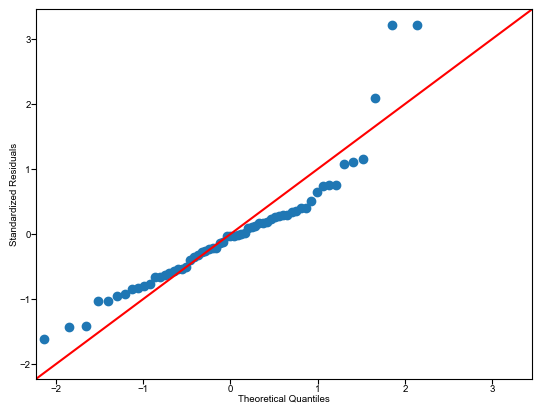

In [30]:
# QQ-plot
import statsmodels.api as sm
import matplotlib.pyplot as plt
# res.anova_std_residuals are standardized residuals obtained from two-way ANOVA (check above)
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

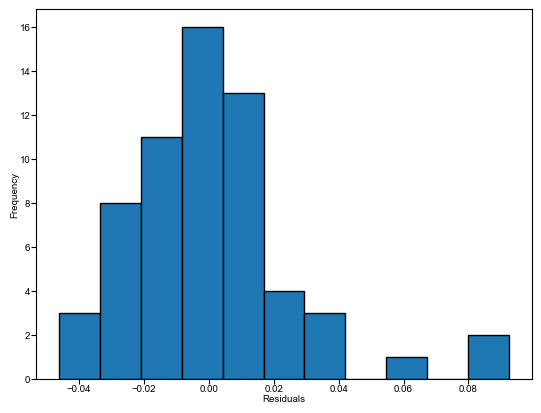

In [31]:
# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [32]:
# Shapiro-Wilk test
import scipy.stats as stats
w, pvalue = stats.shapiro(res.anova_model_out.resid)
print(w, pvalue)

0.8860859870910645 3.711042882059701e-05


In [33]:
# if you have  a stacked table, you can use bioinfokit v1.0.3 or later for the Levene's test
from bioinfokit.analys import stat 
res = stat()
res.levene(df=data, res_var='biomass_yield_cmol_cmol', xfac_var=['Strain', 'Phase'])
res.levene_summary

,Parameter,Value
0,Test statistics (W),1.0412
1,Degrees of freedom (Df),11.0000
2,p value,0.4265


## Ysc in Batch and Fed-batch cultures

### Create DataFrame

In [34]:
offline_data = pd.read_excel("../data/processed_fermentation_data/scale-down_offline_data.xlsx")

# general yield calc
offline_data['o2_yield_mol_cmol'] = offline_data['Consumed_O2']/offline_data['net_glucose_cmol']
offline_data['co2_yield_cmol_cmol'] = offline_data['Formed_CO2']/offline_data['net_glucose_cmol']
offline_data['biomass_yield_cmol_cmol'] = offline_data['net_biomass_cmol']/offline_data['net_glucose_cmol']

# Add strain name
offline_data["Strain"] = offline_data["Strain Batch"].str.split("-",expand=True)[0]

In [35]:
data_feed = offline_data[(offline_data["Condition"] == "control") & ((offline_data["Timepoint (#)"] == "S02") | (offline_data["Timepoint (#)"] == "S05"))][["Parent Culture", "Strain", "Timepoint (#)", "Formed_CO2"]]
feed_biomass_data = data_feed.pivot(index=["Parent Culture", "Strain"], columns="Timepoint (#)", values="Formed_CO2")
feed_biomass_data["CO2_difference"] = feed_biomass_data["S05"] - feed_biomass_data["S02"]
feed_biomass_data = feed_biomass_data.reset_index()
feed_biomass_data = feed_biomass_data[["Parent Culture", "Strain", "CO2_difference"]]
feed_biomass_data.columns.name = None
feed_biomass_data.head()

,Parent Culture,Strain,CO2_difference
0,DDB_PD_117_AMBR_DDB35-005_R05_Main_,DDB35,0.431051
1,DDB_PD_117_AMBR_DDB35-005_R06_Main_,DDB35,0.436409
2,DDB_PD_117_AMBR_DDB35-005_R07_Main_,DDB35,0.439439
3,DDB_PD_121_AMBR_DDB35-006_R05_Main_,DDB35,0.438693
4,DDB_PD_121_AMBR_SDT173-002_R07_Main_,SDT173,0.491667


In [36]:
data_feed = offline_data[(offline_data["Condition"] == "control") & ((offline_data["Timepoint (#)"] == "S02") | (offline_data["Timepoint (#)"] == "S05"))][["Parent Culture", "Strain", "Timepoint (#)", "net_glucose_cmol"]]
feed_glucose_data = data_feed.pivot(index=["Parent Culture", "Strain"], columns="Timepoint (#)", values="net_glucose_cmol")
feed_glucose_data["glucose_difference"] = feed_glucose_data["S05"] - feed_glucose_data["S02"]
feed_glucose_data = feed_glucose_data.reset_index()
feed_glucose_data = feed_glucose_data[["Parent Culture", "Strain", "glucose_difference"]]
feed_glucose_data.columns.name = None
feed_glucose_data.head()

,Parent Culture,Strain,glucose_difference
0,DDB_PD_117_AMBR_DDB35-005_R05_Main_,DDB35,1.020044
1,DDB_PD_117_AMBR_DDB35-005_R06_Main_,DDB35,1.020120
2,DDB_PD_117_AMBR_DDB35-005_R07_Main_,DDB35,1.020056
3,DDB_PD_121_AMBR_DDB35-006_R05_Main_,DDB35,1.020021
4,DDB_PD_121_AMBR_SDT173-002_R07_Main_,SDT173,1.020063


In [37]:
data_feed = pd.merge(left=feed_biomass_data, right=feed_glucose_data, how="left")
data_feed["co2_yield_cmol_cmol"] = data_feed["CO2_difference"]/data_feed["glucose_difference"]
data_feed = data_feed[["Strain", "co2_yield_cmol_cmol"]]
data_feed["Phase"] = "Fed-batch"
data_feed

,Strain,co2_yield_cmol_cmol,Phase
0,DDB35,0.422581,Fed-batch
1,DDB35,0.427801,Fed-batch
2,DDB35,0.430799,Fed-batch
3,DDB35,0.430082,Fed-batch
4,SDT173,0.481997,Fed-batch
5,SDT178,0.508013,Fed-batch
6,SDT180,0.443790,Fed-batch
7,SDT201,0.480322,Fed-batch
8,SDT202,0.424181,Fed-batch
9,DDB35,0.431740,Fed-batch


In [38]:
offline_copy = offline_data.copy()

offline_copy['co2_yield_cmol_cmol'] = offline_copy['Formed_CO2']/offline_copy['net_glucose_cmol']
data_batch = offline_copy[offline_copy['Timepoint (#)'] == 'S02'][["Strain", "co2_yield_cmol_cmol"]]
data_batch["Phase"] = "Batch"
data_batch.head()

,Strain,co2_yield_cmol_cmol,Phase
1,DDB35,0.285707,Batch
6,DDB35,0.290779,Batch
11,DDB35,0.291977,Batch
16,DDB35,0.304340,Batch
21,DDB35,0.323066,Batch


In [39]:
data = pd.concat([data_feed, data_batch])

In [40]:
len(data[data["Phase"] == "Batch"])

41

In [41]:
len(data[data["Phase"] == "Fed-batch"])

20

C:\Users\jonas\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


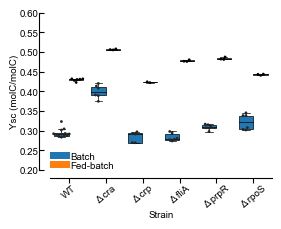

In [42]:
# formatting
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5

plt.rcParams['axes.labelpad']= 0.5
# plt.rcParams['ylabel.pad']= 0

mm_per_inch = 24.5

height_mm = 50
width_mm = 70

fig, ax = plt.subplots(figsize=(width_mm/mm_per_inch,height_mm/mm_per_inch))

df_plotting = data.copy()

order_df = pd.DataFrame()
order_df["Strain"] = ["DDB35", "SDT178", "SDT202", "SDT201", "SDT173", "SDT180"]
order_df["Strain_name"] = ["WT",u"\u0394"+" cra", u"\u0394"+" crp", u"\u0394"+" fliA", u"\u0394"+" prpR", u"\u0394"+" rpoS"]
order_df["order"]  = [1,2,3,4,5,6]

df_plotting = pd.merge(left=df_plotting,right=order_df,how="left")
df_plotting = df_plotting.sort_values("order")

PROPS = {
    'boxprops':{'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}

sns.boxplot(
    x="Strain_name", 
    y="co2_yield_cmol_cmol", 
    hue="Phase",
    hue_order=["Batch", "Fed-batch"],
    data=df_plotting, 
    palette="tab10",
    saturation=1,
    fliersize=0,
    linewidth=0.5,
    ax=ax, 
    **PROPS
) 

sns.swarmplot(
    data=df_plotting,
    x="Strain_name", 
    y="co2_yield_cmol_cmol",
    hue="Phase",
    hue_order=["Batch", "Fed-batch"],
    ax=ax,
    color="k",
    size=2,
    dodge=True
)

ax.set_ylim(0.2,0.6)

ax.spines[["top","right"]].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.set_ylabel("Ysc (molC/molC)");
ax.set_xlabel("Strain");
ax.spines["left"].set_position(("axes", -0.05))
ax.spines["bottom"].set_position(("axes", -0.05));
ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=40)

# ax.text(-0.1, 1.05, 'C', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes, fontsize=10);


legend_elements = [
    Patch(facecolor=cm.tab10(0), edgecolor='black',linewidth=0),
    Patch(facecolor=cm.tab10(1), edgecolor='black',linewidth=0)
]

ax.legend(
    legend_elements, 
    ["Batch", "Fed-batch"], 
    fancybox=False,
    bbox_to_anchor=(0.0,0.0),
    loc='lower left',
    ncol=1, 
    # edgecolor='black',
    columnspacing=0.1,
    handletextpad=0.05,
    labelspacing = 0,
    # title='Strain:',
    framealpha=0,
    borderpad=0,
    borderaxespad=0
);

# ax.plot([-0.2,0.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=0, y=0.645, s="***",horizontalalignment="center", verticalalignment="center")

# ax.plot([0.8,1.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=1, y=0.645, s="ns",horizontalalignment="center", verticalalignment="center")

# ax.plot([1.8,2.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=2, y=0.645, s="ns",horizontalalignment="center", verticalalignment="center")

# ax.plot([2.8,3.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=3, y=0.645, s="ns",horizontalalignment="center", verticalalignment="center")

# ax.plot([3.8,4.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=4, y=0.645, s="*",horizontalalignment="center", verticalalignment="center")

# ax.plot([4.8,5.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=5, y=0.645, s="***",horizontalalignment="center", verticalalignment="center")

C:\Users\jonas\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


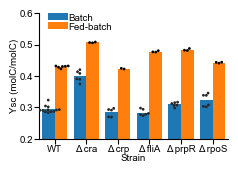

In [43]:
# formatting
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5

plt.rcParams['axes.labelpad']= 0.5
# plt.rcParams['ylabel.pad']= 0

height_mm = 48
width_mm = 71

mm_per_inch = 24.5

fig = plt.figure(figsize=(width_mm/mm_per_inch,height_mm/mm_per_inch))
spec = fig.add_gridspec(nrows=height_mm, ncols=width_mm)
# frame_ax=fig.add_subplot(spec[:,:])
ax = fig.add_subplot(spec[:-8,11:])

df_plotting = data.copy()

order_df = pd.DataFrame()
order_df["Strain"] = ["DDB35", "SDT178", "SDT202", "SDT201", "SDT173", "SDT180"]
order_df["Strain_name"] = ["WT",u"\u0394"+" cra", u"\u0394"+" crp", u"\u0394"+" fliA", u"\u0394"+" prpR", u"\u0394"+" rpoS"]
order_df["order"]  = [1,2,3,4,5,6]

df_plotting = pd.merge(left=df_plotting,right=order_df,how="left")
df_plotting = df_plotting.sort_values("order")

PROPS = {
    'boxprops':{'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}

sns.barplot(
    x="Strain_name", 
    y="co2_yield_cmol_cmol", 
    hue="Phase",
    hue_order=["Batch", "Fed-batch"],
    data=df_plotting, 
    palette="tab10",
    saturation=1,
#     fliersize=0,
#     linewidth=0.5,
    errorbar=None,
    ax=ax, 
#     **PROPS
) 

sns.swarmplot(
    data=df_plotting,
    x="Strain_name", 
    y="co2_yield_cmol_cmol",
    hue="Phase",
    hue_order=["Batch", "Fed-batch"],
    ax=ax,
    color="k",
    size=2,
    dodge=True,
)

ax.set_ylim(0.2,0.6)

ax.spines[["top","right"]].set_visible(False)
# ax.tick_params(axis="y",direction="in")
ax.set_ylabel("Ysc (molC/molC)");
ax.set_xlabel("Strain");
# ax.spines["left"].set_position(("axes", -0.05))
# ax.spines["bottom"].set_position(("axes", -0.05));
ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=0)

# ax.text(-0.1, 1.05, 'C', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes, fontsize=10);


legend_elements = [
    Patch(facecolor=cm.tab10(0), edgecolor='black',linewidth=0),
    Patch(facecolor=cm.tab10(1), edgecolor='black',linewidth=0)
]

ax.legend(
    legend_elements, 
    ["Batch", "Fed-batch"], 
    fancybox=False,
    bbox_to_anchor=(0.05,1.0),
    loc='upper left',
    ncol=1, 
    # edgecolor='black',
    columnspacing=0.1,
    handletextpad=0.05,
    labelspacing = 0,
    # title='Strain:',
    framealpha=0,
    borderpad=0,
    borderaxespad=0
);

# ax.plot([-0.2,0.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=0, y=0.645, s="***",horizontalalignment="center", verticalalignment="center")

# ax.plot([0.8,1.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=1, y=0.645, s="ns",horizontalalignment="center", verticalalignment="center")

# ax.plot([1.8,2.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=2, y=0.645, s="ns",horizontalalignment="center", verticalalignment="center")

# ax.plot([2.8,3.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=3, y=0.645, s="ns",horizontalalignment="center", verticalalignment="center")

# ax.plot([3.8,4.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=4, y=0.645, s="*",horizontalalignment="center", verticalalignment="center")

# ax.plot([4.8,5.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=5, y=0.645, s="***",horizontalalignment="center", verticalalignment="center")

### Perform ANOVA

In [44]:
data.head()

,Strain,co2_yield_cmol_cmol,Phase
0,DDB35,0.422581,Fed-batch
1,DDB35,0.427801,Fed-batch
2,DDB35,0.430799,Fed-batch
3,DDB35,0.430082,Fed-batch
4,SDT173,0.481997,Fed-batch


In [45]:
model = ols('co2_yield_cmol_cmol ~ C(Strain) + C(Phase) + C(Strain):C(Phase)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_table

,sum_sq,df,F,PR(>F)
Intercept,1.037212,1.0,7873.004792,8.795584e-56
C(Strain),0.059050,5.0,89.644786,1.870519e-23
C(Phase),0.073022,1.0,554.274559,2.288010e-28
C(Strain):C(Phase),0.011067,5.0,16.801488,1.210021e-09
Residual,0.006455,49.0,NaN,NaN


In [46]:
# ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
res = stat()
res.anova_stat(df=data, res_var='co2_yield_cmol_cmol', anova_model='co2_yield_cmol_cmol~C(Strain)+C(Phase)+C(Strain):C(Phase)',ss_typ=3)
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
Intercept,1.0,1.037212,1.037212,7873.004792,8.795584e-56
C(Strain),5.0,0.059050,0.011810,89.644786,1.870519e-23
C(Phase),1.0,0.073022,0.073022,554.274559,2.288010e-28
C(Strain):C(Phase),5.0,0.011067,0.002213,16.801488,1.210021e-09
Residual,49.0,0.006455,0.000132,NaN,NaN


In [47]:
# we will use bioinfokit (v1.0.3 or later) for performing tukey HSD test
# check documentation here https://github.com/reneshbedre/bioinfokit
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
# for main effect Strain
res.tukey_hsd(df=data, res_var='co2_yield_cmol_cmol', xfac_var='Strain', anova_model='co2_yield_cmol_cmol~C(Strain)+C(Phase)+C(Strain):C(Phase)', ss_typ=3)
res.tukey_summary

C:\Users\jonas\anaconda3\lib\site-packages\bioinfokit\analys.py:421: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,DDB35,SDT173,0.028163,0.014267,0.042058,8.499661,0.001000
1,DDB35,SDT178,0.095964,0.082068,0.109860,28.962405,0.001000
2,DDB35,SDT180,0.023356,0.009460,0.037251,7.048826,0.001000
3,DDB35,SDT201,0.009119,-0.004777,0.023015,2.752190,0.388925
4,DDB35,SDT202,0.015353,0.000191,0.030514,4.246695,0.045598
5,SDT173,SDT178,0.067801,0.051756,0.083846,17.721256,0.001000
6,SDT173,SDT180,0.004807,-0.011238,0.020853,1.256460,0.900000
7,SDT173,SDT201,0.019044,0.002998,0.035089,4.977456,0.011481
8,SDT173,SDT202,0.043515,0.026362,0.060669,10.639096,0.001000
9,SDT178,SDT180,0.072608,0.056563,0.088654,18.977716,0.001000


In [48]:
# Note: p-value 0.001 from tukey_hsd output should be interpreted as <=0.001

# for main effect Condition
res.tukey_hsd(df=data, res_var='co2_yield_cmol_cmol', xfac_var='Phase', anova_model='co2_yield_cmol_cmol ~ C(Strain) + C(Phase) + C(Strain):C(Phase)',ss_typ=3)
res.tukey_summary

C:\Users\jonas\anaconda3\lib\site-packages\bioinfokit\analys.py:421: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Fed-batch,Batch,0.144599,0.138308,0.15089,65.321927,0.001


In [49]:
# for interaction effect between Strain and Condition
res.tukey_hsd(df=data, res_var='co2_yield_cmol_cmol', xfac_var=['Strain','Phase'], anova_model='co2_yield_cmol_cmol ~ C(Strain) + C(Phase) + C(Strain):C(Phase)',ss_typ=3)
res.tukey_summary

C:\Users\jonas\anaconda3\lib\site-packages\bioinfokit\analys.py:387: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[(ele1, ele2)] = df[(df[xfac_var[0]] == ele1) &


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(DDB35, Fed-batch)","(DDB35, Batch)",0.135113,0.115426,0.154799,33.294881,0.001000
1,"(DDB35, Fed-batch)","(SDT173, Fed-batch)",0.054362,0.026522,0.082203,9.472472,0.001000
2,"(DDB35, Fed-batch)","(SDT173, Batch)",0.120050,0.097318,0.142781,25.619641,0.001000
3,"(DDB35, Fed-batch)","(SDT178, Fed-batch)",0.077409,0.049569,0.105250,13.488346,0.001000
4,"(DDB35, Fed-batch)","(SDT178, Batch)",0.029871,0.007140,0.052603,6.374835,0.002185
...,...,...,...,...,...,...,...
61,"(SDT201, Fed-batch)","(SDT202, Fed-batch)",0.054524,0.018582,0.090466,7.359185,0.001000
62,"(SDT201, Fed-batch)","(SDT202, Batch)",0.193714,0.164961,0.222468,32.682388,0.001000
63,"(SDT201, Batch)","(SDT202, Fed-batch)",0.139687,0.107539,0.171834,21.079121,0.001000
64,"(SDT201, Batch)","(SDT202, Batch)",0.000497,-0.023345,0.024338,0.101027,0.900000


In [50]:
res.tukey_summary[(res.tukey_summary["group2"] == ("DDB35", "Batch")) & (res.tukey_summary["group1"] == ("DDB35", "Fed-batch"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(DDB35, Fed-batch)","(DDB35, Batch)",0.135113,0.115426,0.154799,33.294881,0.001


In [51]:
res.tukey_summary[(res.tukey_summary["group2"] == ("SDT178", "Batch")) & (res.tukey_summary["group1"] == ("SDT178", "Fed-batch"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
38,"(SDT178, Fed-batch)","(SDT178, Batch)",0.107281,0.07944,0.135121,18.693377,0.001


In [52]:
res.tukey_summary[(res.tukey_summary["group2"] == ("SDT202", "Batch")) & (res.tukey_summary["group1"] == ("SDT202", "Fed-batch"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
65,"(SDT202, Fed-batch)","(SDT202, Batch)",0.13919,0.106249,0.172132,20.497998,0.001


In [53]:
res.tukey_summary[(res.tukey_summary["group2"] == ("SDT201", "Batch")) & (res.tukey_summary["group1"] == ("SDT201", "Fed-batch"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
60,"(SDT201, Fed-batch)","(SDT201, Batch)",0.194211,0.16637,0.222051,33.84074,0.001


In [54]:
res.tukey_summary[(res.tukey_summary["group2"] == ("SDT173", "Batch")) & (res.tukey_summary["group1"] == ("SDT173", "Fed-batch"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
21,"(SDT173, Fed-batch)","(SDT173, Batch)",0.174412,0.146571,0.202252,30.390821,0.001


In [55]:
res.tukey_summary[(res.tukey_summary["group2"] == ("SDT180", "Batch")) & (res.tukey_summary["group1"] == ("SDT180", "Fed-batch"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
51,"(SDT180, Fed-batch)","(SDT180, Batch)",0.120229,0.092389,0.14807,20.949632,0.001


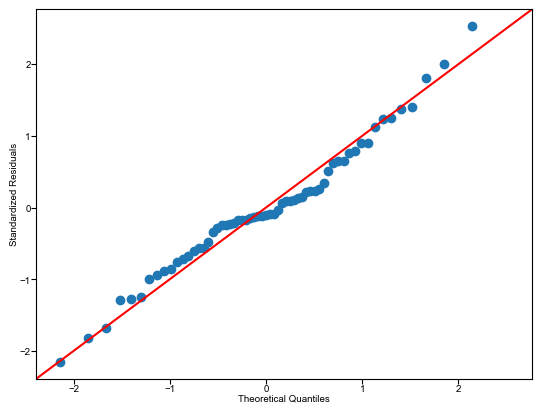

In [56]:
# QQ-plot
import statsmodels.api as sm
import matplotlib.pyplot as plt
# res.anova_std_residuals are standardized residuals obtained from two-way ANOVA (check above)
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

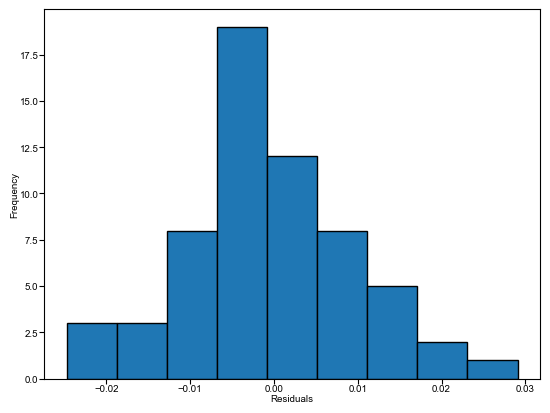

In [57]:
# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [58]:
# Shapiro-Wilk test
import scipy.stats as stats
w, pvalue = stats.shapiro(res.anova_model_out.resid)
print(w, pvalue)

0.981494128704071 0.48351311683654785


In [59]:
# if you have  a stacked table, you can use bioinfokit v1.0.3 or later for the Levene's test
from bioinfokit.analys import stat 
res = stat()
res.levene(df=data, res_var='co2_yield_cmol_cmol', xfac_var=['Strain', 'Phase'])
res.levene_summary

,Parameter,Value
0,Test statistics (W),3.8285
1,Degrees of freedom (Df),11.0000
2,p value,0.0005


## Ysx in Control and scale-down cultures

### Create DataFrame

In [60]:
offline_data = pd.read_excel("../data/processed_fermentation_data/scale-down_offline_data.xlsx")

# general yield calc
offline_data['o2_yield_mol_cmol'] = offline_data['Consumed_O2']/offline_data['net_glucose_cmol']
offline_data['co2_yield_cmol_cmol'] = offline_data['Formed_CO2']/offline_data['net_glucose_cmol']
offline_data['biomass_yield_cmol_cmol'] = offline_data['net_biomass_cmol']/offline_data['net_glucose_cmol']

# for batch data, because at low conc, OD was more accurate
offline_data['net_biomass_cmol_from_OD'] = (offline_data["OD"]*0.28)*(offline_data["Liquid_volume"]/1000)/24.6

# Add strain name
offline_data["Strain"] = offline_data["Strain Batch"].str.split("-",expand=True)[0]

In [61]:
data_feed_S02 = offline_data[offline_data["Timepoint (#)"] == "S02"][["Parent Culture", "Strain", "Timepoint (#)", "Condition", "net_biomass_cmol_from_OD"]]
data_feed_S02 = data_feed_S02.rename(columns={"net_biomass_cmol_from_OD":"net_biomass_cmol"})
data_feed_S05 = offline_data[offline_data["Timepoint (#)"] == "S05"][["Parent Culture", "Strain", "Timepoint (#)", "Condition", "net_biomass_cmol"]]
data_feed = pd.concat([data_feed_S02, data_feed_S05])
feed_biomass_data = data_feed.pivot(index=["Parent Culture", "Strain", "Condition"], columns="Timepoint (#)", values="net_biomass_cmol")
feed_biomass_data["biomass_difference"] = feed_biomass_data["S05"] - feed_biomass_data["S02"]
feed_biomass_data = feed_biomass_data.reset_index()
feed_biomass_data = feed_biomass_data[["Parent Culture", "Strain", "Condition", "biomass_difference"]]
feed_biomass_data.columns.name = None
feed_biomass_data

,Parent Culture,Strain,Condition,biomass_difference
0,DDB_PD_117_AMBR_DDB35-005_R05_Main_,DDB35,control,0.636644
1,DDB_PD_117_AMBR_DDB35-005_R06_Main_,DDB35,control,0.641830
2,DDB_PD_117_AMBR_DDB35-005_R07_Main_,DDB35,control,0.626817
3,DDB_PD_117_AMBR_DDB35-005_R08_Main_,DDB35,scale-down,0.593494
4,DDB_PD_117_AMBR_DDB35-005_R09_Main_,DDB35,scale-down,0.597327
5,DDB_PD_117_AMBR_DDB35-005_R10_Main_,DDB35,scale-down,0.590152
6,DDB_PD_121_AMBR_DDB35-006_R05_Main_,DDB35,control,0.629796
7,DDB_PD_121_AMBR_DDB35-006_R06_Main_,DDB35,scale-down,0.603150
8,DDB_PD_121_AMBR_SDT173-002_R07_Main_,SDT173,control,0.555040
9,DDB_PD_121_AMBR_SDT173-002_R08_Main_,SDT173,scale-down,0.507619


In [62]:
data_feed = offline_data[(offline_data["Timepoint (#)"] == "S02") | (offline_data["Timepoint (#)"] == "S05")][["Parent Culture", "Strain", "Condition", "Timepoint (#)", "net_glucose_cmol"]]
feed_glucose_data = data_feed.pivot(index=["Parent Culture", "Strain", "Condition"], columns="Timepoint (#)", values="net_glucose_cmol")
feed_glucose_data["glucose_difference"] = feed_glucose_data["S05"] - feed_glucose_data["S02"]
feed_glucose_data = feed_glucose_data.reset_index()
feed_glucose_data = feed_glucose_data[["Parent Culture", "Strain", "Condition", "glucose_difference"]]
feed_glucose_data.columns.name = None
feed_glucose_data

,Parent Culture,Strain,Condition,glucose_difference
0,DDB_PD_117_AMBR_DDB35-005_R05_Main_,DDB35,control,1.020044
1,DDB_PD_117_AMBR_DDB35-005_R06_Main_,DDB35,control,1.020120
2,DDB_PD_117_AMBR_DDB35-005_R07_Main_,DDB35,control,1.020056
3,DDB_PD_117_AMBR_DDB35-005_R08_Main_,DDB35,scale-down,1.019836
4,DDB_PD_117_AMBR_DDB35-005_R09_Main_,DDB35,scale-down,1.019988
5,DDB_PD_117_AMBR_DDB35-005_R10_Main_,DDB35,scale-down,1.019931
6,DDB_PD_121_AMBR_DDB35-006_R05_Main_,DDB35,control,1.020021
7,DDB_PD_121_AMBR_DDB35-006_R06_Main_,DDB35,scale-down,1.019999
8,DDB_PD_121_AMBR_SDT173-002_R07_Main_,SDT173,control,1.020063
9,DDB_PD_121_AMBR_SDT173-002_R08_Main_,SDT173,scale-down,1.019143


In [63]:
data_feed = pd.merge(left=feed_biomass_data, right=feed_glucose_data, how="left")
data_feed["biomass_yield_cmol_cmol"] = data_feed["biomass_difference"]/data_feed["glucose_difference"]
data_feed = data_feed[["Strain", "Condition", "biomass_yield_cmol_cmol"]]
data_feed

,Strain,Condition,biomass_yield_cmol_cmol
0,DDB35,control,0.624134
1,DDB35,control,0.629171
2,DDB35,control,0.614493
3,DDB35,scale-down,0.581950
4,DDB35,scale-down,0.585621
5,DDB35,scale-down,0.578619
6,DDB35,control,0.617435
7,DDB35,scale-down,0.591324
8,SDT173,control,0.544123
9,SDT173,scale-down,0.498084


In [64]:
data = data_feed.copy()

In [65]:
data

,Strain,Condition,biomass_yield_cmol_cmol
0,DDB35,control,0.624134
1,DDB35,control,0.629171
2,DDB35,control,0.614493
3,DDB35,scale-down,0.581950
4,DDB35,scale-down,0.585621
5,DDB35,scale-down,0.578619
6,DDB35,control,0.617435
7,DDB35,scale-down,0.591324
8,SDT173,control,0.544123
9,SDT173,scale-down,0.498084


In [66]:
df_plotting

,Strain,co2_yield_cmol_cmol,Phase,Strain_name,order
0,DDB35,0.422581,Fed-batch,WT,1
20,DDB35,0.285707,Batch,WT,1
23,DDB35,0.304340,Batch,WT,1
24,DDB35,0.323066,Batch,WT,1
25,DDB35,0.301468,Batch,WT,1
...,...,...,...,...,...
32,SDT180,0.345237,Batch,Δ rpoS,6
56,SDT180,0.338386,Batch,Δ rpoS,6
57,SDT180,0.301500,Batch,Δ rpoS,6
45,SDT180,0.303014,Batch,Δ rpoS,6


C:\Users\jonas\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


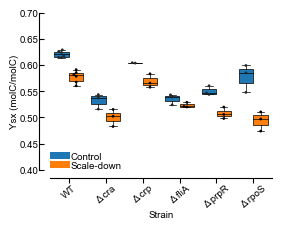

In [67]:
# formatting
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5

plt.rcParams['axes.labelpad']= 0.5
# plt.rcParams['ylabel.pad']= 0

mm_per_inch = 24.5

height_mm = 50
width_mm = 70

fig, ax = plt.subplots(figsize=(width_mm/mm_per_inch,height_mm/mm_per_inch))

df_plotting = data.copy()

order_df = pd.DataFrame()
order_df["Strain"] = ["DDB35", "SDT178", "SDT202", "SDT201", "SDT173", "SDT180"]
order_df["Strain_name"] = ["WT",u"\u0394"+" cra", u"\u0394"+" crp", u"\u0394"+" fliA", u"\u0394"+" prpR", u"\u0394"+" rpoS"]
order_df["order"]  = [1,2,3,4,5,6]

df_plotting = pd.merge(left=df_plotting,right=order_df,how="left")
df_plotting = df_plotting.sort_values("order")

PROPS = {
    'boxprops':{'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}

sns.boxplot(
    x="Strain_name", 
    y="biomass_yield_cmol_cmol", 
    hue="Condition",
    hue_order=["control", "scale-down"],
    data=df_plotting, 
    palette="tab10",
    saturation=1,
    fliersize=0,
    linewidth=0.5,
    ax=ax, 
    **PROPS
) 

sns.swarmplot(
    data=df_plotting,
    x="Strain_name", 
    y="biomass_yield_cmol_cmol",
    hue="Condition",
    hue_order=["control", "scale-down"],
    ax=ax,
    color="k",
    size=2,
    dodge=True
)

ax.set_ylim(0.4,0.7)

ax.spines[["top","right"]].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.set_ylabel("Ysx (molC/molC)");
ax.set_xlabel("Strain");
ax.spines["left"].set_position(("axes", -0.05))
ax.spines["bottom"].set_position(("axes", -0.05));
ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=40)

# ax.text(-0.1, 1.05, 'C', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes, fontsize=10);


legend_elements = [
    Patch(facecolor=cm.tab10(0), edgecolor='black',linewidth=0),
    Patch(facecolor=cm.tab10(1), edgecolor='black',linewidth=0)
]

ax.legend(
    legend_elements, 
    ["Control", "Scale-down"], 
    fancybox=False,
    bbox_to_anchor=(0.0,0.0),
    loc='lower left',
    ncol=1, 
    # edgecolor='black',
    columnspacing=0.1,
    handletextpad=0.05,
    labelspacing = 0,
    # title='Strain:',
    framealpha=0,
    borderpad=0,
    borderaxespad=0
);

# ax.plot([-0.2,0.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=0, y=0.645, s="***",horizontalalignment="center", verticalalignment="center")

# ax.plot([0.8,1.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=1, y=0.645, s="ns",horizontalalignment="center", verticalalignment="center")

# ax.plot([1.8,2.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=2, y=0.645, s="ns",horizontalalignment="center", verticalalignment="center")

# ax.plot([2.8,3.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=3, y=0.645, s="ns",horizontalalignment="center", verticalalignment="center")

# ax.plot([3.8,4.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=4, y=0.645, s="*",horizontalalignment="center", verticalalignment="center")

# ax.plot([4.8,5.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=5, y=0.645, s="***",horizontalalignment="center", verticalalignment="center")

C:\Users\jonas\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


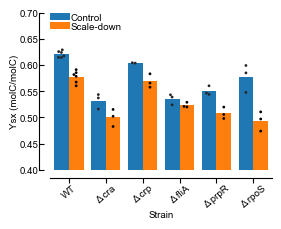

In [68]:
# formatting
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5

plt.rcParams['axes.labelpad']= 0.5
# plt.rcParams['ylabel.pad']= 0

mm_per_inch = 24.5

height_mm = 50
width_mm = 70

fig, ax = plt.subplots(figsize=(width_mm/mm_per_inch,height_mm/mm_per_inch))

df_plotting = data.copy()

order_df = pd.DataFrame()
order_df["Strain"] = ["DDB35", "SDT178", "SDT202", "SDT201", "SDT173", "SDT180"]
order_df["Strain_name"] = ["WT",u"\u0394"+" cra", u"\u0394"+" crp", u"\u0394"+" fliA", u"\u0394"+" prpR", u"\u0394"+" rpoS"]
order_df["order"]  = [1,2,3,4,5,6]

df_plotting = pd.merge(left=df_plotting,right=order_df,how="left")
df_plotting = df_plotting.sort_values("order")

PROPS = {
    'boxprops':{'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}

sns.barplot(
    x="Strain_name", 
    y="biomass_yield_cmol_cmol", 
    hue="Condition",
    hue_order=["control", "scale-down"],
    data=df_plotting, 
    palette="tab10",
    saturation=1,
#     fliersize=0,
#     linewidth=0.5,
    ax=ax,
    errorbar=None
#     **PROPS
) 

sns.swarmplot(
    data=df_plotting,
    x="Strain_name", 
    y="biomass_yield_cmol_cmol",
    hue="Condition",
    hue_order=["control", "scale-down"],
    ax=ax,
    color="k",
    size=2,
    dodge=True
)

ax.set_ylim(0.4,0.7)

ax.spines[["top","right"]].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.set_ylabel("Ysx (molC/molC)");
ax.set_xlabel("Strain");
ax.spines["left"].set_position(("axes", -0.05))
ax.spines["bottom"].set_position(("axes", -0.05));
ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=40)

# ax.text(-0.1, 1.05, 'C', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes, fontsize=10);


legend_elements = [
    Patch(facecolor=cm.tab10(0), edgecolor='black',linewidth=0),
    Patch(facecolor=cm.tab10(1), edgecolor='black',linewidth=0)
]

ax.legend(
    legend_elements, 
    ["Control", "Scale-down"], 
    fancybox=False,
    bbox_to_anchor=(0.0,1.0),
    loc='upper left',
    ncol=1, 
    # edgecolor='black',
    columnspacing=0.1,
    handletextpad=0.05,
    labelspacing = 0,
    # title='Strain:',
    framealpha=0,
    borderpad=0,
    borderaxespad=0
);

# ax.plot([-0.2,0.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=0, y=0.645, s="***",horizontalalignment="center", verticalalignment="center")

# ax.plot([0.8,1.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=1, y=0.645, s="ns",horizontalalignment="center", verticalalignment="center")

# ax.plot([1.8,2.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=2, y=0.645, s="ns",horizontalalignment="center", verticalalignment="center")

# ax.plot([2.8,3.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=3, y=0.645, s="ns",horizontalalignment="center", verticalalignment="center")

# ax.plot([3.8,4.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=4, y=0.645, s="*",horizontalalignment="center", verticalalignment="center")

# ax.plot([4.8,5.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=5, y=0.645, s="***",horizontalalignment="center", verticalalignment="center")

### Perform ANOVA

In [69]:
data.head()

,Strain,Condition,biomass_yield_cmol_cmol
0,DDB35,control,0.624134
1,DDB35,control,0.629171
2,DDB35,control,0.614493
3,DDB35,scale-down,0.581950
4,DDB35,scale-down,0.585621


In [70]:
model = ols('biomass_yield_cmol_cmol ~ C(Strain) + C(Condition) + C(Strain):C(Condition)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_table

,sum_sq,df,F,PR(>F)
Intercept,2.313545,1.0,13688.541275,2.408201e-40
C(Strain),0.026314,5.0,31.138667,8.126547e-11
C(Condition),0.005639,1.0,33.361561,2.950117e-06
C(Strain):C(Condition),0.004141,5.0,4.900373,2.267039e-03
Residual,0.004901,29.0,NaN,NaN


In [71]:
# ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
res = stat()
res.anova_stat(df=data, res_var='biomass_yield_cmol_cmol', anova_model='biomass_yield_cmol_cmol~C(Strain)+C(Condition)+C(Strain):C(Condition)',ss_typ=3)
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
Intercept,1.0,2.313545,2.313545,13688.541275,2.408201e-40
C(Strain),5.0,0.026314,0.005263,31.138667,8.126547e-11
C(Condition),1.0,0.005639,0.005639,33.361561,2.950117e-06
C(Strain):C(Condition),5.0,0.004141,0.000828,4.900373,2.267039e-03
Residual,29.0,0.004901,0.000169,NaN,NaN


In [72]:
# we will use bioinfokit (v1.0.3 or later) for performing tukey HSD test
# check documentation here https://github.com/reneshbedre/bioinfokit
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
# for main effect Strain
res.tukey_hsd(df=data, res_var='biomass_yield_cmol_cmol', xfac_var='Strain', anova_model='biomass_yield_cmol_cmol~C(Strain)+C(Condition)+C(Strain):C(Condition)', ss_typ=3)
res.tukey_summary

C:\Users\jonas\anaconda3\lib\site-packages\bioinfokit\analys.py:421: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,DDB35,SDT173,0.070096,0.050280,0.089912,15.250276,0.001000
1,DDB35,SDT178,0.082998,0.063182,0.102813,18.057262,0.001000
2,DDB35,SDT180,0.063566,0.043751,0.083382,13.829659,0.001000
3,DDB35,SDT201,0.069816,0.050000,0.089631,15.189326,0.001000
4,DDB35,SDT202,0.016212,-0.004883,0.037307,3.313159,0.210052
5,SDT173,SDT178,0.012902,-0.009979,0.035783,2.430921,0.527148
6,SDT173,SDT180,0.006530,-0.016351,0.029411,1.230291,0.900000
7,SDT173,SDT201,0.000280,-0.022601,0.023161,0.052784,0.900000
8,SDT173,SDT202,0.053884,0.029886,0.077882,9.680072,0.001000
9,SDT178,SDT180,0.019432,-0.003449,0.042313,3.661212,0.132146


In [73]:
# Note: p-value 0.001 from tukey_hsd output should be interpreted as <=0.001

# for main effect Condition
res.tukey_hsd(df=data, res_var='biomass_yield_cmol_cmol', xfac_var='Condition', anova_model='biomass_yield_cmol_cmol ~ C(Strain) + C(Condition) + C(Strain):C(Condition)',ss_typ=3)
res.tukey_summary

C:\Users\jonas\anaconda3\lib\site-packages\bioinfokit\analys.py:421: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,control,scale-down,0.040393,0.032086,0.048701,14.063633,0.001


In [74]:
# for interaction effect between Strain and Condition
res.tukey_hsd(df=data, res_var='biomass_yield_cmol_cmol', xfac_var=['Strain','Condition'], anova_model='biomass_yield_cmol_cmol ~ C(Strain) + C(Condition) + C(Strain):C(Condition)',ss_typ=3)
res.tukey_summary

C:\Users\jonas\anaconda3\lib\site-packages\bioinfokit\analys.py:387: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[(ele1, ele2)] = df[(df[xfac_var[0]] == ele1) &


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(DDB35, control)","(DDB35, scale-down)",0.043353,0.016741,0.069966,8.168422,0.001000
1,"(DDB35, control)","(SDT173, control)",0.070515,0.037922,0.103108,10.848084,0.001000
2,"(DDB35, control)","(SDT173, scale-down)",0.113030,0.080437,0.145623,17.388553,0.001000
3,"(DDB35, control)","(SDT178, control)",0.088563,0.055970,0.121156,13.624503,0.001000
4,"(DDB35, control)","(SDT178, scale-down)",0.120787,0.088193,0.153380,18.581811,0.001000
...,...,...,...,...,...,...,...
61,"(SDT201, control)","(SDT202, control)",0.068706,0.026629,0.110784,8.187312,0.001000
62,"(SDT201, control)","(SDT202, scale-down)",0.033541,-0.004094,0.071176,4.468634,0.116089
63,"(SDT201, scale-down)","(SDT202, control)",0.080700,0.038622,0.122777,9.616520,0.001000
64,"(SDT201, scale-down)","(SDT202, scale-down)",0.045535,0.007899,0.083170,6.066537,0.008191


In [75]:
res.tukey_summary[(res.tukey_summary["group2"] == ("DDB35", "scale-down")) & (res.tukey_summary["group1"] == ("DDB35", "control"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(DDB35, control)","(DDB35, scale-down)",0.043353,0.016741,0.069966,8.168422,0.001


In [76]:
res.tukey_summary[(res.tukey_summary["group2"] == ("SDT178", "scale-down")) & (res.tukey_summary["group1"] == ("SDT178", "control"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
38,"(SDT178, control)","(SDT178, scale-down)",0.032224,-0.005412,0.069859,4.293154,0.148633


In [77]:
res.tukey_summary[(res.tukey_summary["group2"] == ("SDT202", "scale-down")) & (res.tukey_summary["group1"] == ("SDT202", "control"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
65,"(SDT202, control)","(SDT202, scale-down)",0.035165,-0.006912,0.077243,4.190444,0.171473


In [78]:
res.tukey_summary[(res.tukey_summary["group2"] == ("SDT201", "scale-down")) & (res.tukey_summary["group1"] == ("SDT201", "control"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
60,"(SDT201, control)","(SDT201, scale-down)",0.011994,-0.025642,0.049629,1.597902,0.9


In [79]:
res.tukey_summary[(res.tukey_summary["group2"] == ("SDT173", "scale-down")) & (res.tukey_summary["group1"] == ("SDT173", "control"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
21,"(SDT173, control)","(SDT173, scale-down)",0.042515,0.004879,0.08015,5.664212,0.016732


In [80]:
res.tukey_summary[(res.tukey_summary["group2"] == ("SDT180", "scale-down")) & (res.tukey_summary["group1"] == ("SDT180", "control"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
51,"(SDT180, control)","(SDT180, scale-down)",0.083516,0.04588,0.121151,11.126733,0.001


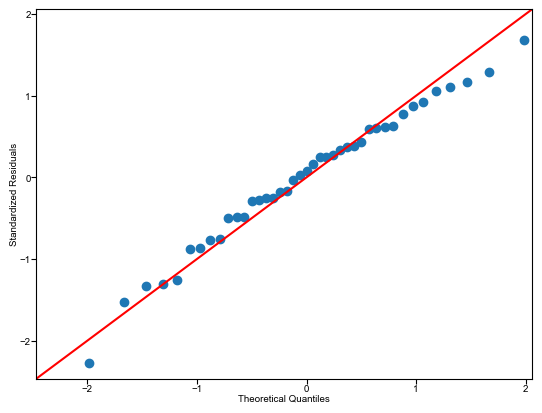

In [81]:
# QQ-plot
import statsmodels.api as sm
import matplotlib.pyplot as plt
# res.anova_std_residuals are standardized residuals obtained from two-way ANOVA (check above)
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

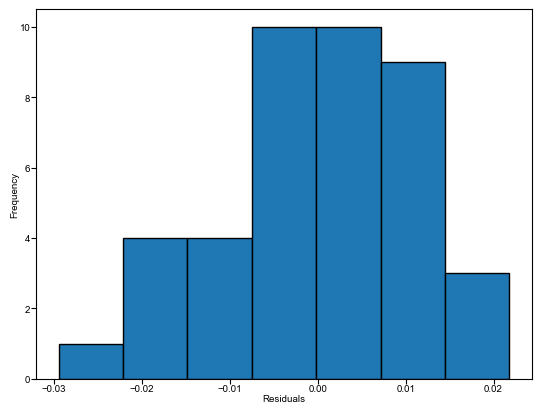

In [82]:
# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [83]:
# Shapiro-Wilk test
import scipy.stats as stats
w, pvalue = stats.shapiro(res.anova_model_out.resid)
print(w, pvalue)

0.98358154296875 0.8081451058387756


In [84]:
# if you have  a stacked table, you can use bioinfokit v1.0.3 or later for the Levene's test
from bioinfokit.analys import stat 
res = stat()
res.levene(df=data, res_var='biomass_yield_cmol_cmol', xfac_var=['Strain', 'Condition'])
res.levene_summary

,Parameter,Value
0,Test statistics (W),0.7149
1,Degrees of freedom (Df),11.0000
2,p value,0.7150


## Ysc in Control and scale-down cultures

### Create DataFrame

In [85]:
offline_data = pd.read_excel("../data/processed_fermentation_data/scale-down_offline_data.xlsx")

# general yield calc
offline_data['o2_yield_mol_cmol'] = offline_data['Consumed_O2']/offline_data['net_glucose_cmol']
offline_data['co2_yield_cmol_cmol'] = offline_data['Formed_CO2']/offline_data['net_glucose_cmol']
offline_data['biomass_yield_cmol_cmol'] = offline_data['net_biomass_cmol']/offline_data['net_glucose_cmol']

# Add strain name
offline_data["Strain"] = offline_data["Strain Batch"].str.split("-",expand=True)[0]

In [86]:
data_feed_S02 = offline_data[offline_data["Timepoint (#)"] == "S02"][["Parent Culture", "Strain", "Timepoint (#)", "Condition", "Formed_CO2"]]
data_feed_S05 = offline_data[offline_data["Timepoint (#)"] == "S05"][["Parent Culture", "Strain", "Timepoint (#)", "Condition", "Formed_CO2"]]
data_feed = pd.concat([data_feed_S02, data_feed_S05])
feed_biomass_data = data_feed.pivot(index=["Parent Culture", "Strain", "Condition"], columns="Timepoint (#)", values="Formed_CO2")
feed_biomass_data["CO2_difference"] = feed_biomass_data["S05"] - feed_biomass_data["S02"]
feed_biomass_data = feed_biomass_data.reset_index()
feed_biomass_data = feed_biomass_data[["Parent Culture", "Strain", "Condition", "CO2_difference"]]
feed_biomass_data.columns.name = None
feed_biomass_data

,Parent Culture,Strain,Condition,CO2_difference
0,DDB_PD_117_AMBR_DDB35-005_R05_Main_,DDB35,control,0.431051
1,DDB_PD_117_AMBR_DDB35-005_R06_Main_,DDB35,control,0.436409
2,DDB_PD_117_AMBR_DDB35-005_R07_Main_,DDB35,control,0.439439
3,DDB_PD_117_AMBR_DDB35-005_R08_Main_,DDB35,scale-down,0.496892
4,DDB_PD_117_AMBR_DDB35-005_R09_Main_,DDB35,scale-down,0.491544
5,DDB_PD_117_AMBR_DDB35-005_R10_Main_,DDB35,scale-down,0.484691
6,DDB_PD_121_AMBR_DDB35-006_R05_Main_,DDB35,control,0.438693
7,DDB_PD_121_AMBR_DDB35-006_R06_Main_,DDB35,scale-down,0.490432
8,DDB_PD_121_AMBR_SDT173-002_R07_Main_,SDT173,control,0.491667
9,DDB_PD_121_AMBR_SDT173-002_R08_Main_,SDT173,scale-down,0.567751


In [87]:
data_feed = offline_data[(offline_data["Timepoint (#)"] == "S02") | (offline_data["Timepoint (#)"] == "S05")][["Parent Culture", "Strain", "Condition", "Timepoint (#)", "net_glucose_cmol"]]
feed_glucose_data = data_feed.pivot(index=["Parent Culture", "Strain", "Condition"], columns="Timepoint (#)", values="net_glucose_cmol")
feed_glucose_data["glucose_difference"] = feed_glucose_data["S05"] - feed_glucose_data["S02"]
feed_glucose_data = feed_glucose_data.reset_index()
feed_glucose_data = feed_glucose_data[["Parent Culture", "Strain", "Condition", "glucose_difference"]]
feed_glucose_data.columns.name = None
feed_glucose_data

,Parent Culture,Strain,Condition,glucose_difference
0,DDB_PD_117_AMBR_DDB35-005_R05_Main_,DDB35,control,1.020044
1,DDB_PD_117_AMBR_DDB35-005_R06_Main_,DDB35,control,1.020120
2,DDB_PD_117_AMBR_DDB35-005_R07_Main_,DDB35,control,1.020056
3,DDB_PD_117_AMBR_DDB35-005_R08_Main_,DDB35,scale-down,1.019836
4,DDB_PD_117_AMBR_DDB35-005_R09_Main_,DDB35,scale-down,1.019988
5,DDB_PD_117_AMBR_DDB35-005_R10_Main_,DDB35,scale-down,1.019931
6,DDB_PD_121_AMBR_DDB35-006_R05_Main_,DDB35,control,1.020021
7,DDB_PD_121_AMBR_DDB35-006_R06_Main_,DDB35,scale-down,1.019999
8,DDB_PD_121_AMBR_SDT173-002_R07_Main_,SDT173,control,1.020063
9,DDB_PD_121_AMBR_SDT173-002_R08_Main_,SDT173,scale-down,1.019143


In [88]:
data_feed = pd.merge(left=feed_biomass_data, right=feed_glucose_data, how="left")
data_feed["co2_yield_cmol_cmol"] = data_feed["CO2_difference"]/data_feed["glucose_difference"]
data_feed = data_feed[["Strain", "Condition", "co2_yield_cmol_cmol"]]
data_feed

,Strain,Condition,co2_yield_cmol_cmol
0,DDB35,control,0.422581
1,DDB35,control,0.427801
2,DDB35,control,0.430799
3,DDB35,scale-down,0.487227
4,DDB35,scale-down,0.481911
5,DDB35,scale-down,0.475220
6,DDB35,control,0.430082
7,DDB35,scale-down,0.480816
8,SDT173,control,0.481997
9,SDT173,scale-down,0.557086


In [89]:
data = data_feed.copy()

In [90]:
data

,Strain,Condition,co2_yield_cmol_cmol
0,DDB35,control,0.422581
1,DDB35,control,0.427801
2,DDB35,control,0.430799
3,DDB35,scale-down,0.487227
4,DDB35,scale-down,0.481911
5,DDB35,scale-down,0.475220
6,DDB35,control,0.430082
7,DDB35,scale-down,0.480816
8,SDT173,control,0.481997
9,SDT173,scale-down,0.557086


C:\Users\jonas\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


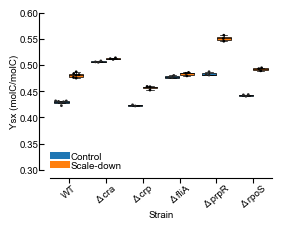

In [91]:
# formatting
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5

plt.rcParams['axes.labelpad']= 0.5
# plt.rcParams['ylabel.pad']= 0

mm_per_inch = 24.5

height_mm = 50
width_mm = 70

fig, ax = plt.subplots(figsize=(width_mm/mm_per_inch,height_mm/mm_per_inch))

df_plotting = data.copy()

order_df = pd.DataFrame()
order_df["Strain"] = ["DDB35", "SDT178", "SDT202", "SDT201", "SDT173", "SDT180"]
order_df["Strain_name"] = ["WT",u"\u0394"+" cra", u"\u0394"+" crp", u"\u0394"+" fliA", u"\u0394"+" prpR", u"\u0394"+" rpoS"]
order_df["order"]  = [1,2,3,4,5,6]

df_plotting = pd.merge(left=df_plotting,right=order_df,how="left")
df_plotting = df_plotting.sort_values("order")

PROPS = {
    'boxprops':{'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}

sns.boxplot(
    x="Strain_name", 
    y="co2_yield_cmol_cmol", 
    hue="Condition",
    hue_order=["control", "scale-down"],
    data=df_plotting, 
    palette="tab10",
    saturation=1,
    fliersize=0,
    linewidth=0.5,
    ax=ax, 
    **PROPS
) 

sns.swarmplot(
    data=df_plotting,
    x="Strain_name", 
    y="co2_yield_cmol_cmol",
    hue="Condition",
    hue_order=["control", "scale-down"],
    ax=ax,
    color="k",
    size=2,
    dodge=True
)

ax.set_ylim(0.3,0.6)

ax.spines[["top","right"]].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.set_ylabel("Ysx (molC/molC)");
ax.set_xlabel("Strain");
ax.spines["left"].set_position(("axes", -0.05))
ax.spines["bottom"].set_position(("axes", -0.05));
ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=40)

# ax.text(-0.1, 1.05, 'C', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes, fontsize=10);


legend_elements = [
    Patch(facecolor=cm.tab10(0), edgecolor='black',linewidth=0),
    Patch(facecolor=cm.tab10(1), edgecolor='black',linewidth=0)
]

ax.legend(
    legend_elements, 
    ["Control", "Scale-down"], 
    fancybox=False,
    bbox_to_anchor=(0.0,0.0),
    loc='lower left',
    ncol=1, 
    # edgecolor='black',
    columnspacing=0.1,
    handletextpad=0.05,
    labelspacing = 0,
    # title='Strain:',
    framealpha=0,
    borderpad=0,
    borderaxespad=0
);

# ax.plot([-0.2,0.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=0, y=0.645, s="***",horizontalalignment="center", verticalalignment="center")

# ax.plot([0.8,1.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=1, y=0.645, s="ns",horizontalalignment="center", verticalalignment="center")

# ax.plot([1.8,2.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=2, y=0.645, s="ns",horizontalalignment="center", verticalalignment="center")

# ax.plot([2.8,3.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=3, y=0.645, s="ns",horizontalalignment="center", verticalalignment="center")

# ax.plot([3.8,4.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=4, y=0.645, s="*",horizontalalignment="center", verticalalignment="center")

# ax.plot([4.8,5.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=5, y=0.645, s="***",horizontalalignment="center", verticalalignment="center")

C:\Users\jonas\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


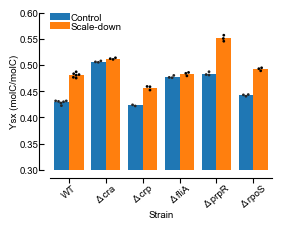

In [92]:
# formatting
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5

plt.rcParams['axes.labelpad']= 0.5
# plt.rcParams['ylabel.pad']= 0

mm_per_inch = 24.5

height_mm = 50
width_mm = 70

fig, ax = plt.subplots(figsize=(width_mm/mm_per_inch,height_mm/mm_per_inch))

df_plotting = data.copy()

order_df = pd.DataFrame()
order_df["Strain"] = ["DDB35", "SDT178", "SDT202", "SDT201", "SDT173", "SDT180"]
order_df["Strain_name"] = ["WT",u"\u0394"+" cra", u"\u0394"+" crp", u"\u0394"+" fliA", u"\u0394"+" prpR", u"\u0394"+" rpoS"]
order_df["order"]  = [1,2,3,4,5,6]

df_plotting = pd.merge(left=df_plotting,right=order_df,how="left")
df_plotting = df_plotting.sort_values("order")

PROPS = {
    'boxprops':{'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}

sns.barplot(
    x="Strain_name", 
    y="co2_yield_cmol_cmol", 
    hue="Condition",
    hue_order=["control", "scale-down"],
    data=df_plotting, 
    palette="tab10",
    saturation=1,
#     fliersize=0,
#     linewidth=0.5,
    ax=ax,
    errorbar=None
#     **PROPS
) 

sns.swarmplot(
    data=df_plotting,
    x="Strain_name", 
    y="co2_yield_cmol_cmol",
    hue="Condition",
    hue_order=["control", "scale-down"],
    ax=ax,
    color="k",
    size=2,
    dodge=True
)

ax.set_ylim(0.3,0.6)

ax.spines[["top","right"]].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.set_ylabel("Ysx (molC/molC)");
ax.set_xlabel("Strain");
ax.spines["left"].set_position(("axes", -0.05))
ax.spines["bottom"].set_position(("axes", -0.05));
ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=40)

# ax.text(-0.1, 1.05, 'C', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes, fontsize=10);


legend_elements = [
    Patch(facecolor=cm.tab10(0), edgecolor='black',linewidth=0),
    Patch(facecolor=cm.tab10(1), edgecolor='black',linewidth=0)
]

ax.legend(
    legend_elements, 
    ["Control", "Scale-down"], 
    fancybox=False,
    bbox_to_anchor=(0.0,1.0),
    loc='upper left',
    ncol=1, 
    # edgecolor='black',
    columnspacing=0.1,
    handletextpad=0.05,
    labelspacing = 0,
    # title='Strain:',
    framealpha=0,
    borderpad=0,
    borderaxespad=0
);

# ax.plot([-0.2,0.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=0, y=0.645, s="***",horizontalalignment="center", verticalalignment="center")

# ax.plot([0.8,1.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=1, y=0.645, s="ns",horizontalalignment="center", verticalalignment="center")

# ax.plot([1.8,2.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=2, y=0.645, s="ns",horizontalalignment="center", verticalalignment="center")

# ax.plot([2.8,3.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=3, y=0.645, s="ns",horizontalalignment="center", verticalalignment="center")

# ax.plot([3.8,4.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=4, y=0.645, s="*",horizontalalignment="center", verticalalignment="center")

# ax.plot([4.8,5.2],[0.64, 0.64],
#        linewidth=1,
#        color="k")
# ax.text(x=5, y=0.645, s="***",horizontalalignment="center", verticalalignment="center")

### Perform ANOVA

In [93]:
data.head()

,Strain,Condition,co2_yield_cmol_cmol
0,DDB35,control,0.422581
1,DDB35,control,0.427801
2,DDB35,control,0.430799
3,DDB35,scale-down,0.487227
4,DDB35,scale-down,0.481911


In [94]:
model = ols('co2_yield_cmol_cmol ~ C(Strain) + C(Condition) + C(Strain):C(Condition)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_table

,sum_sq,df,F,PR(>F)
Intercept,1.104811,1.0,92317.770263,2.361663e-52
C(Strain),0.018321,5.0,306.177059,3.678291e-24
C(Condition),0.008048,1.0,672.466415,1.297881e-21
C(Strain):C(Condition),0.005246,5.0,87.672767,1.342661e-16
Residual,0.000347,29.0,NaN,NaN


In [95]:
# ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
res = stat()
res.anova_stat(df=data, res_var='co2_yield_cmol_cmol', anova_model='co2_yield_cmol_cmol~C(Strain)+C(Condition)+C(Strain):C(Condition)',ss_typ=3)
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
Intercept,1.0,1.104811,1.104811,92317.770263,2.361663e-52
C(Strain),5.0,0.018321,0.003664,306.177059,3.678291e-24
C(Condition),1.0,0.008048,0.008048,672.466415,1.297881e-21
C(Strain):C(Condition),5.0,0.005246,0.001049,87.672767,1.342661e-16
Residual,29.0,0.000347,0.000012,NaN,NaN


In [96]:
# we will use bioinfokit (v1.0.3 or later) for performing tukey HSD test
# check documentation here https://github.com/reneshbedre/bioinfokit
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
# for main effect Strain
res.tukey_hsd(df=data, res_var='co2_yield_cmol_cmol', xfac_var='Strain', anova_model='co2_yield_cmol_cmol~C(Strain)+C(Condition)+C(Strain):C(Condition)', ss_typ=3)
res.tukey_summary

C:\Users\jonas\anaconda3\lib\site-packages\bioinfokit\analys.py:421: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,DDB35,SDT173,0.062315,0.057042,0.067588,50.949009,0.001000
1,DDB35,SDT178,0.054453,0.049180,0.059726,44.520835,0.001000
2,DDB35,SDT180,0.012466,0.007193,0.017739,10.192430,0.001000
3,DDB35,SDT201,0.025436,0.020163,0.030709,20.796766,0.001000
4,DDB35,SDT202,0.011698,0.006085,0.017311,8.984073,0.001000
5,SDT173,SDT178,0.007862,0.001774,0.013951,5.566962,0.005743
6,SDT173,SDT180,0.049849,0.043760,0.055937,35.296233,0.001000
7,SDT173,SDT201,0.036879,0.030790,0.042967,26.112608,0.001000
8,SDT173,SDT202,0.074013,0.067627,0.080399,49.967200,0.001000
9,SDT178,SDT180,0.041987,0.035898,0.048075,29.729270,0.001000


In [97]:
# Note: p-value 0.001 from tukey_hsd output should be interpreted as <=0.001

# for main effect Condition
res.tukey_hsd(df=data, res_var='co2_yield_cmol_cmol', xfac_var='Condition', anova_model='co2_yield_cmol_cmol ~ C(Strain) + C(Condition) + C(Strain):C(Condition)',ss_typ=3)
res.tukey_summary

C:\Users\jonas\anaconda3\lib\site-packages\bioinfokit\analys.py:421: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,control,scale-down,0.036406,0.034196,0.038617,47.634625,0.001


In [98]:
# for interaction effect between Strain and Condition
res.tukey_hsd(df=data, res_var='co2_yield_cmol_cmol', xfac_var=['Strain','Condition'], anova_model='co2_yield_cmol_cmol ~ C(Strain) + C(Condition) + C(Strain):C(Condition)',ss_typ=3)
res.tukey_summary

C:\Users\jonas\anaconda3\lib\site-packages\bioinfokit\analys.py:387: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[(ele1, ele2)] = df[(df[xfac_var[0]] == ele1) &


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(DDB35, control)","(DDB35, scale-down)",0.051794,0.044712,0.058875,36.673326,0.001
1,"(DDB35, control)","(SDT173, control)",0.054362,0.045689,0.063035,31.428627,0.001
2,"(DDB35, control)","(SDT173, scale-down)",0.122061,0.113388,0.130734,70.567798,0.001
3,"(DDB35, control)","(SDT178, control)",0.077409,0.068736,0.086082,44.752859,0.001
4,"(DDB35, control)","(SDT178, scale-down)",0.083290,0.074617,0.091963,48.152754,0.001
...,...,...,...,...,...,...,...
61,"(SDT201, control)","(SDT202, control)",0.054524,0.043327,0.065721,24.416974,0.001
62,"(SDT201, control)","(SDT202, scale-down)",0.020849,0.010834,0.030864,10.438632,0.001
63,"(SDT201, scale-down)","(SDT202, control)",0.060154,0.048958,0.071351,26.938335,0.001
64,"(SDT201, scale-down)","(SDT202, scale-down)",0.026479,0.016465,0.036494,13.257598,0.001


In [99]:
res.tukey_summary[(res.tukey_summary["group2"] == ("DDB35", "scale-down")) & (res.tukey_summary["group1"] == ("DDB35", "control"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(DDB35, control)","(DDB35, scale-down)",0.051794,0.044712,0.058875,36.673326,0.001


In [100]:
res.tukey_summary[(res.tukey_summary["group2"] == ("SDT178", "scale-down")) & (res.tukey_summary["group1"] == ("SDT178", "control"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
38,"(SDT178, control)","(SDT178, scale-down)",0.005881,-0.004134,0.015895,2.944396,0.621642


In [101]:
res.tukey_summary[(res.tukey_summary["group2"] == ("SDT202", "scale-down")) & (res.tukey_summary["group1"] == ("SDT202", "control"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
65,"(SDT202, control)","(SDT202, scale-down)",0.033675,0.022478,0.044872,15.080378,0.001


In [102]:
res.tukey_summary[(res.tukey_summary["group2"] == ("SDT201", "scale-down")) & (res.tukey_summary["group1"] == ("SDT201", "control"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
60,"(SDT201, control)","(SDT201, scale-down)",0.00563,-0.004384,0.015645,2.818967,0.671736


In [103]:
res.tukey_summary[(res.tukey_summary["group2"] == ("SDT173", "scale-down")) & (res.tukey_summary["group1"] == ("SDT173", "control"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
21,"(SDT173, control)","(SDT173, scale-down)",0.067699,0.057684,0.077714,33.895516,0.001


In [104]:
res.tukey_summary[(res.tukey_summary["group2"] == ("SDT180", "scale-down")) & (res.tukey_summary["group1"] == ("SDT180", "control"))]

,group1,group2,Diff,Lower,Upper,q-value,p-value
51,"(SDT180, control)","(SDT180, scale-down)",0.04986,0.039845,0.059874,24.963623,0.001


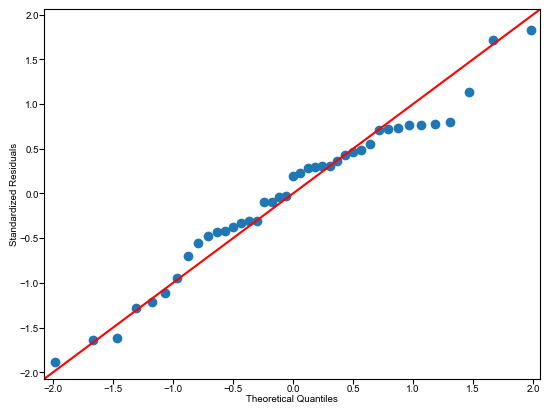

In [105]:
# QQ-plot
import statsmodels.api as sm
import matplotlib.pyplot as plt
# res.anova_std_residuals are standardized residuals obtained from two-way ANOVA (check above)
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

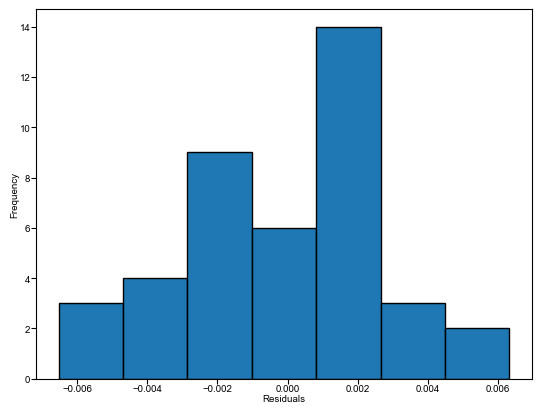

In [106]:
# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [107]:
# Shapiro-Wilk test
import scipy.stats as stats
w, pvalue = stats.shapiro(res.anova_model_out.resid)
print(w, pvalue)

0.9727931618690491 0.4233343303203583


In [108]:
# if you have  a stacked table, you can use bioinfokit v1.0.3 or later for the Levene's test
from bioinfokit.analys import stat 
res = stat()
res.levene(df=data, res_var='co2_yield_cmol_cmol', xfac_var=['Strain', 'Condition'])
res.levene_summary

,Parameter,Value
0,Test statistics (W),0.5006
1,Degrees of freedom (Df),11.0000
2,p value,0.8871
